### This notebook shows the implementation of the selection-bias correction algorithm. 

## Load synethic data

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

In [2]:
import numpy as np
from sklearn.datasets import load_iris
import random
from sklearn.datasets.samples_generator import make_blobs
from numpy import where
from matplotlib import pyplot

In [3]:
X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=1)

In [4]:
# create a scatter plot of points colored by class value
def plot_samples(X, y, classes=3):
    # plot points for each class
    for i in range(classes):
        # select indices of points with each class label
        samples_ix = where(y == i)
        # plot points for this class with a given color
        pyplot.scatter(X[samples_ix, 0], X[samples_ix, 1])

In [5]:
# generate samples for blobs problem with a given random seed
def samples_for_seed(seed):
    # generate samples
    X, y = make_blobs(n_samples=1000, centers=3, n_features=2, cluster_std=2, random_state=seed)
    return X, y

Text(0.5, 1.0, 'target')

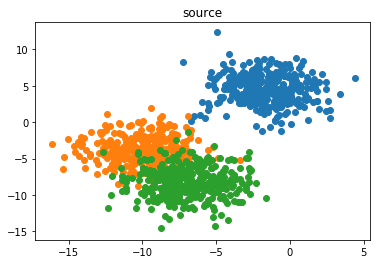

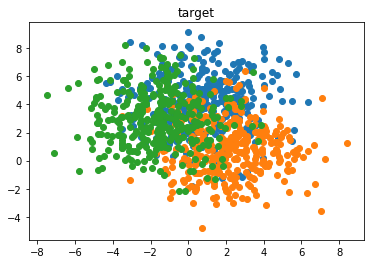

In [6]:
s,y_s = samples_for_seed(1)
t,y_t = samples_for_seed(0)

plot_samples(s, y_s)
pyplot.title("source")
pyplot.figure()
plot_samples(t, y_t)
pyplot.title("target")

### train an multiclass SVM on source and apply to the target

In [7]:
from sklearn import svm
from sklearn.metrics import accuracy_score

In [8]:
clf_weights = svm.SVC()
clf_weights.fit(s, y_s)

y_pred=clf_weights.predict(t)
y_true=y_t
st=accuracy_score(y_true, y_pred)
print ("training on source and apply model to target::score=", st)

training on source and apply model to target::score= 0.331


In [9]:
clf_weights = svm.SVC()
clf_weights.fit(t, y_t)

y_pred=clf_weights.predict(s)
y_true=y_s
ts=accuracy_score(y_true, y_pred)
print ("training on targete and apply model to source::score=", ts)

training on targete and apply model to source::score= 0.419


### label the source with sigma=0, target with sigma=1

In [10]:
from sklearn.linear_model import LogisticRegression
s_sig = np.ones((len(s)))
t_sig = np.zeros((len(t)))
st_samples = np.concatenate((s, t))
st_sigvals = np.concatenate((s_sig, t_sig))
clf = LogisticRegression(random_state=0, solver='lbfgs',
                         multi_class='ovr').fit(st_samples, st_sigvals)

In [11]:
clf.classes_

array([0., 1.])

In [12]:
clf.predict_proba(st_samples)

array([[0.26074874, 0.73925126],
       [0.05151514, 0.94848486],
       [0.97982377, 0.02017623],
       ...,
       [0.62968551, 0.37031449],
       [0.33556709, 0.66443291],
       [0.79429231, 0.20570769]])

In [13]:
sample_weights_ = np.array([1./v[1] for v in clf.predict_proba(st_samples)])

In [14]:
sample_weights_

array([ 1.35272004,  1.05431309, 49.56327861, ...,  2.70040745,
        1.50504285,  4.86126698])

### Train a new SVM on the source + some fraction of the target data and test it on the rest of the target data

In [47]:
from sklearn import svm
from sklearn.metrics import accuracy_score

frac=0.1
train_sample_len = len(s)+int(np.round(frac*len(t)))
train_Xs = st_samples[:train_sample_len]
train_ys = np.concatenate((y_s, y_t[:int(np.round(frac*len(t)))]))
train_samples_weights = sample_weights_[:train_sample_len]
test_Xt = st_samples[train_sample_len:]
test_yt = y_t[int(np.round(frac*len(t))):]

In [48]:
clf_weights = svm.SVC()
clf_weights.fit(train_Xs, train_ys, sample_weight=train_samples_weights)

SVC(C=1.0, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='rbf', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [49]:
y_pred=clf_weights.predict(test_Xt)
y_true=test_yt
st_reweight_acc= accuracy_score(y_true, y_pred)
print ("training on source+target w/reweighting and apply model to target::score=", st_reweight_acc)

training on source+target w/reweighting and apply model to target::score= 0.5344444444444445


Note the difference in performance.  Before reweighting, training on the source and applying the model on the target data yields an accuracy score of 0.33 and after reweighting and using some of the target samples with the new weights, we achieve a score of 0.53.  An approvement of 20% !